In [1]:
#Importing Required modules
import os
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import rdFMCS
from rdkit.Chem import rdFingerprintGenerator
from rdkit.Chem import AllChem
from rdkit.Chem import DataStructs
from rdkit.Chem import rdRGroupDecomposition
from rdkit.Chem import rdmolops
from rdkit.Chem import RDConfig
from rdkit.Chem import PandasTools
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.Scaffolds import MurckoScaffold

from collections import defaultdict
from itertools import product
import igraph
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
import re
IPythonConsole.ipython_useSVG = True

In [2]:
#creting a function to...
def gengraph(mols,fpgen , threshold=0.7):
    fps = [fpgen.GetFingerprint(m) for m in mols]
    num_v = len(mols)
    graph = igraph.Graph()
    graph.add_vertices(num_v)
    for i in range(num_v):
        for j in range(i):
            if DataStructs.TanimotoSimilarity(fps[i], fps[j]) >= threshold:
                graph.add_edge(i, j)
    return graph

In [3]:
#Creating a function that joins two molecules together
def makebond(target, chain):
    newmol = Chem.RWMol(rdmolops.CombineMols(target, chain))
    atoms = newmol.GetAtoms()
    mapper = defaultdict(list)
    for idx, atm in enumerate(atoms):
        atom_map_num = atm.GetAtomMapNum()
        mapper[atom_map_num].append(idx)
    for idx, a_list in mapper.items():
        if len(a_list) == 2:
            atm1, atm2 = a_list
            rm_atoms = [newmol.GetAtomWithIdx(atm1),newmol.GetAtomWithIdx(atm2)]
            nbr1 = [x.GetOtherAtom(newmol.GetAtomWithIdx(atm1)) for x in newmol.GetAtomWithIdx(atm1).GetBonds()][0]
            nbr1.SetAtomMapNum(idx)
            nbr2 = [x.GetOtherAtom(newmol.GetAtomWithIdx(atm2)) for x in newmol.GetAtomWithIdx(atm2).GetBonds()][0]
            nbr2.SetAtomMapNum(idx)
    newmol.AddBond(nbr1.GetIdx(), nbr2.GetIdx(), order=Chem.rdchem.BondType.SINGLE)
    nbr1.SetAtomMapNum(0)
    nbr2.SetAtomMapNum(0)
    newmol.RemoveAtom(rm_atoms[0].GetIdx())
    newmol.RemoveAtom(rm_atoms[1].GetIdx())
    newmol = newmol.GetMol()
    return newmol

In [4]:
#Creating a function that enumerates molcules
def enumeratemol(core,rg, maxmol=10000):
    dataset = rg.GetRGroupsAsColumns()
    labels = list(dataset.keys())
    pat = re.compile("R\d+")
    labels = [label for label in labels if pat.match(label)]
    rgs = np.asarray([dataset[label] for label in labels])
    i, j = rgs.shape
    combs = [k for k in product(range(j), repeat=i)]
    res = []
    for i in combs:
        mol = core
        for idx,j in enumerate(i):
            mol = makebond(mol, rgs[idx][j])
        AllChem.Compute2DCoords(mol)
        mol = Chem.RemoveHs(mol)
        res.append(mol)
    return res

In [5]:
fpgen = rdFingerprintGenerator.GetMorganGenerator(2)

In [18]:
mols = [m for m in Chem.SDMolSupplier('core.sdf')]
for mol in mols:
    AllChem.Compute2DCoords(mol)
fps = [fpgen.GetFingerprint(m) for m in mols]


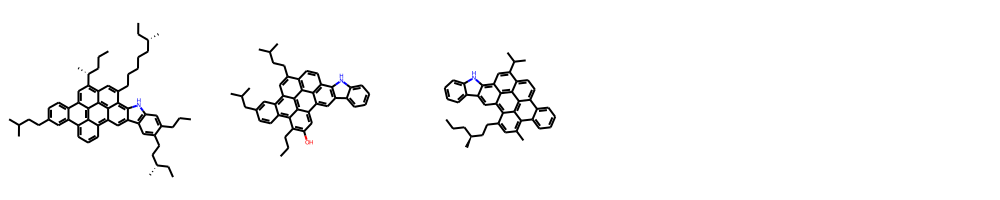

In [19]:
Draw.MolsToGridImage(mols, molsPerRow=5)

In [20]:
graph = gengraph(mols, fpgen, 0.4)
blks=graph.blocks()
simmols_idx = sorted(list(blks), key=lambda x: len(x), reverse=True)
simmols_idx

[[0, 1, 2]]

In [21]:
simmols = [mols[i] for i in simmols_idx[0]]
scaff = [MurckoScaffold.GetScaffoldForMol(m) for m in simmols]
scaff

In [22]:
mcs1 = rdFMCS.FindMCS(scaff, threshold=0.7)
mcs2 = rdFMCS.FindMCS(scaff, threshold=0.7, 
                      completeRingsOnly=True,
                      matchValences=True,
                      bondCompare=rdFMCS.BondCompare.CompareOrderExact,
                      atomCompare=rdFMCS.AtomCompare.CompareElements,
                      )
mcs3 = rdFMCS.FindMCS(scaff, threshold=0.7,
                      ringMatchesRingOnly=True,
                      completeRingsOnly=True,
                      atomCompare=rdFMCS.AtomCompare.CompareAny)

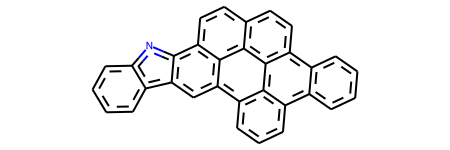

In [23]:
Chem.MolFromSmarts(mcs1.smartsString)

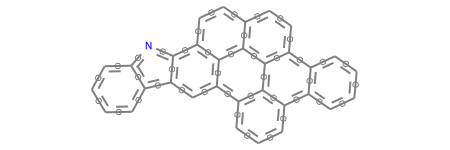

In [24]:
Chem.MolFromSmarts(mcs2.smartsString)

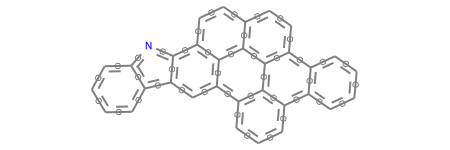

In [25]:
Chem.MolFromSmarts(mcs3.smartsString)

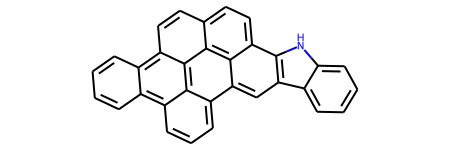

In [26]:
mols_has_core = []
core = Chem.MolFromSmarts(mcs2.smartsString)
for mol in mols:
    if mol.HasSubstructMatch(core):
        AllChem.Compute2DCoords(mol)
        mols_has_core.append(mol)
def getMCSSmiles(mol, mcs):
    mcsp = Chem.MolFromSmarts(mcs.smartsString)
    match = mol.GetSubstructMatch(mcsp)
    smi = Chem.MolFragmentToSmiles(mol, atomsToUse=match)
    return smi
mcs_smi = getMCSSmiles(mols_has_core[0], mcs1)
core = Chem.MolFromSmiles(mcs_smi)
core

only if these 3 has same core, this program will run

In [27]:
rgp = rdRGroupDecomposition.RGroupDecompositionParameters()
rgp.removeHydrogensPostMatch = True
rgp.alignment =True
rgp.removeAllHydrogenRGroups=True
rg = rdRGroupDecomposition.RGroupDecomposition(core, rgp)
for mol in mols_has_core:
    rg.Add(mol)
rg

In [28]:
rg.Process()

True

In [29]:
frame = pd.DataFrame(rg.GetRGroupsAsColumns())
frame["Smiles"] = [Chem.MolToSmiles(mol) for mol in mols_has_core]
PandasTools.AddMoleculeColumnToFrame(frame)

,ROMol,Smiles,Core,R1,R2
0,,CCCc1cc2[nH]c3c(cc4c5cccc6c7cc(CCC(C)C)ccc7c7c...,,,
1,,CCCc1c(O)cc2c3cc4c5ccccc5[nH]c4c4ccc5c(CCC(C)C...,,,
2,,CCC[C@H](C)CCc1cc(C)c2c3ccccc3c3ccc4c(C(C)C)cc...,,,

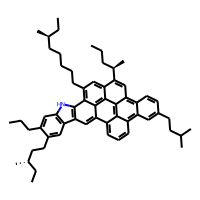
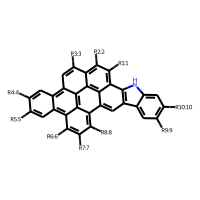
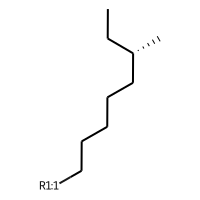
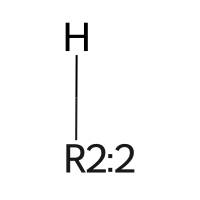
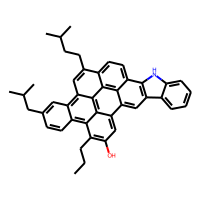
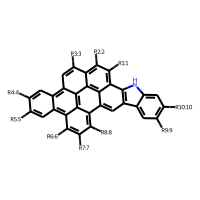
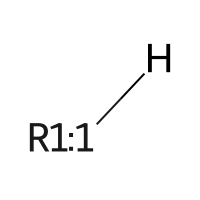
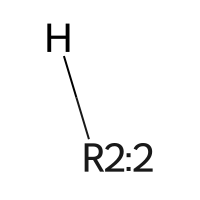
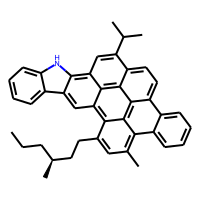
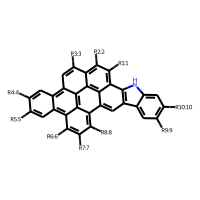
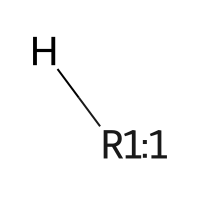
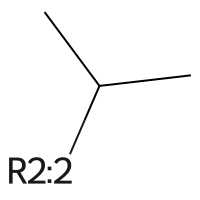

In [30]:
frame = frame[["ROMol", "Smiles", "Core", "R1", "R2"]]
frame['Core']=frame['Core'].apply(Chem.RemoveHs)
frame.head()

In [31]:
dataset = rg.GetRGroupsAsColumns()
core =  Chem.RemoveHs(dataset["Core"][0])

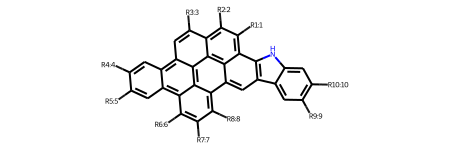

In [32]:
core

In [33]:
res = enumeratemol(core,rg)

C:\Users\Kakashi\anaconda3\envs\my-rdkit-env\lib\site-packages\rdkit\Chem\Draw\IPythonConsole.py:252: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  warnings.warn(


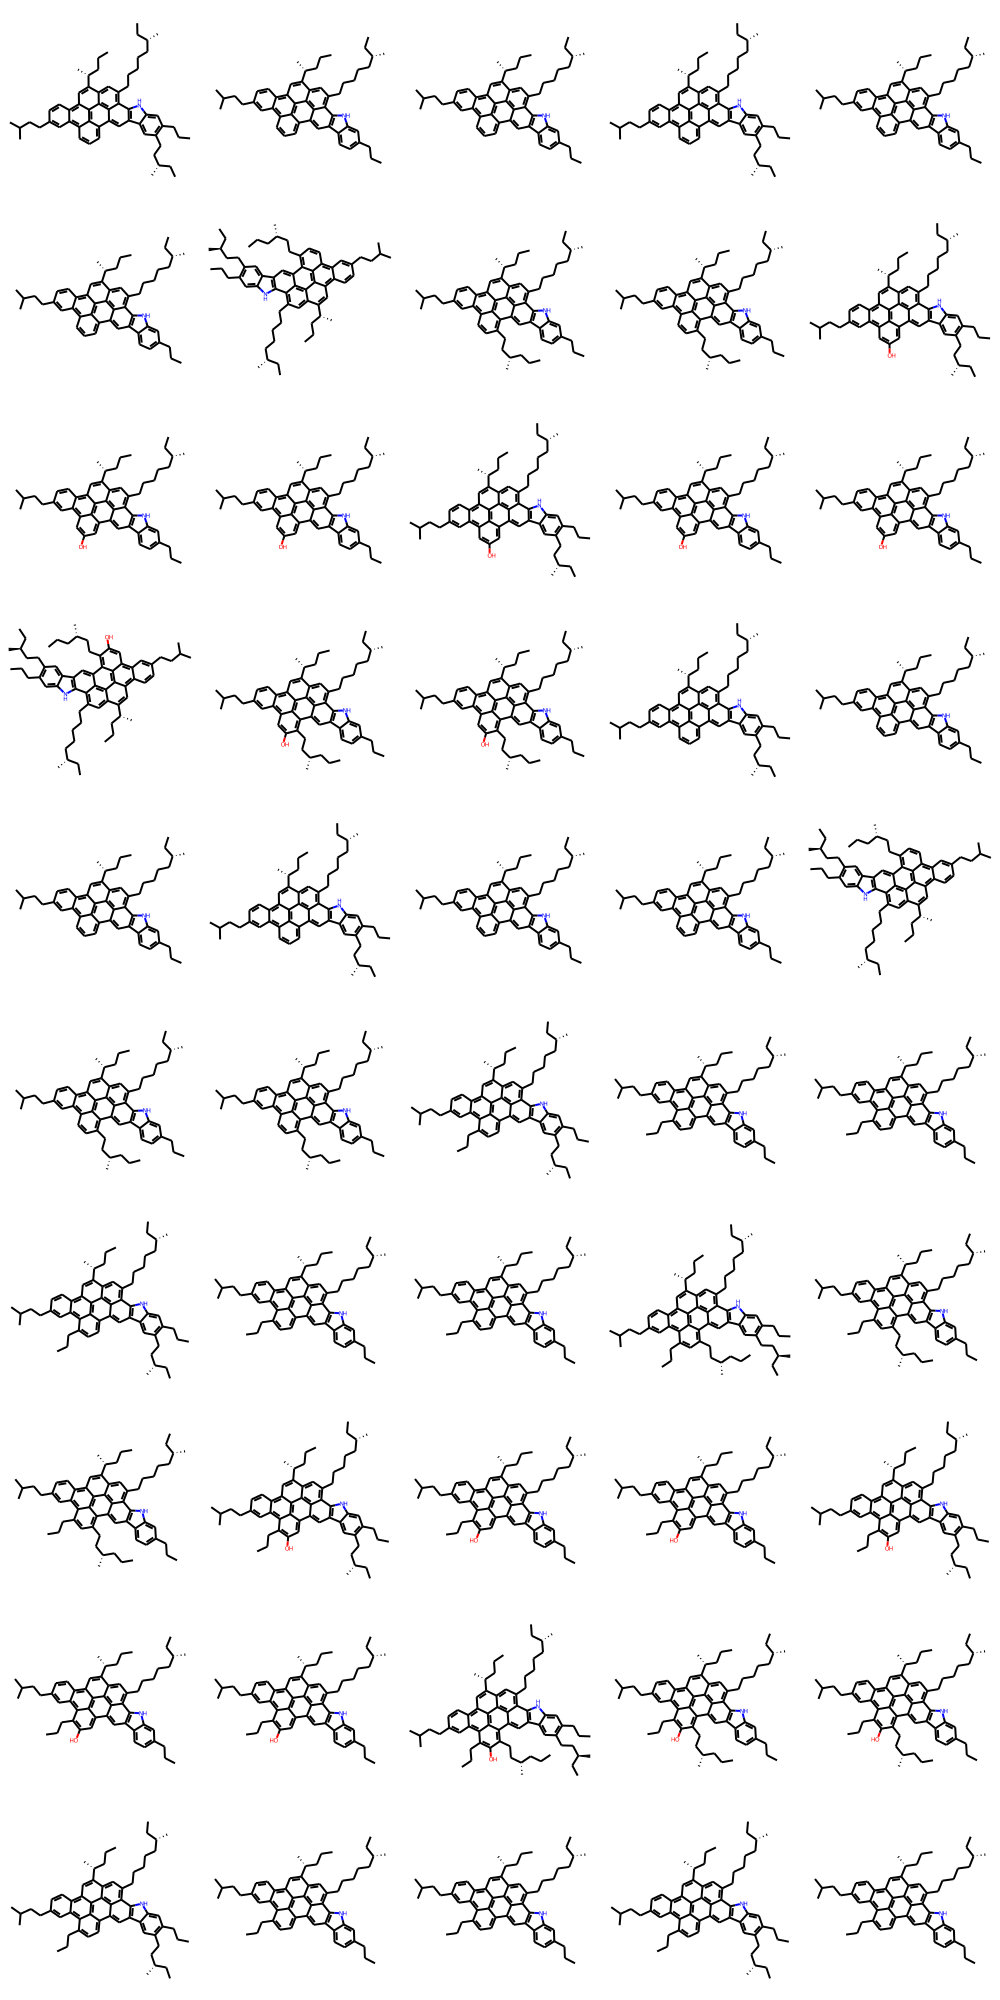

In [34]:
Draw.MolsToGridImage(res[:200],molsPerRow=5)

In [35]:
print(len(res),'molecules generated')

59049 molecules generated


In [36]:
print(res)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [1]:
listsmiles=[]
for m in res:
    print(Chem.MolToSmiles(m))
    listsmiles.append(Chem.MolToSmiles(m))
len(listsmiles)

NameError: name 'res' is not defined

In [38]:
print(listsmiles)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [39]:
unique=set(listsmiles)

In [40]:
for i in (unique):
    print(i)

CCC[C@H](C)CCc1ccc2c3ccc(CC(C)C)cc3c3cc(CCC(C)C)c4ccc5c6[nH]c7ccc(CC[C@@H](C)CC)cc7c6cc6c1c2c3c4c56
CCCc1cc2[nH]c3c(cc4c5ccc(C)c6c7cc(CCC(C)C)c(CC(C)C)cc7c7ccc8c(C(C)C)cc3c4c8c7c56)c2cc1CC[C@@H](C)CC
CCCc1ccc2c3cc4c5ccccc5[nH]c4c4c(CCCCC[C@@H](C)CC)c(C(C)C)c5c([C@H](C)CCC)cc6c7ccc(CCC(C)C)cc7c1c2c6c5c34
CCCc1c(O)cc2c3cc4c5ccccc5[nH]c4c4c(CCCCC[C@@H](C)CC)cc5c([C@H](C)CCC)cc6c7ccccc7c1c2c6c5c34
CCC[C@@H](C)c1cc2c3cc(CC(C)C)c(CCC(C)C)cc3c3c(C)c(O)cc4c5cc6c7ccccc7[nH]c6c6c(CCCCC[C@@H](C)CC)cc1c(c56)c2c43
CCCc1cc(CC[C@@H](C)CCC)c2c3cc4c5ccccc5[nH]c4c4cc(C(C)C)c5ccc6c7cc(CC(C)C)ccc7c1c2c6c5c43
CCCc1cc2[nH]c3c(cc4c5cc(O)c(CCC)c6c7cc(CCC(C)C)c(CC(C)C)cc7c7cc([C@H](C)CCC)c8c(C(C)C)c(CCCCC[C@@H](C)CC)c3c4c8c7c56)c2cc1CC[C@@H](C)CC
CCC[C@H](C)CCc1ccc2c3ccc(CC(C)C)cc3c3cc([C@H](C)CCC)c4c(C(C)C)c(CCCCC[C@@H](C)CC)c5c6[nH]c7ccccc7c6cc6c1c2c3c4c65
CC[C@H](C)CCc1ccc2[nH]c3c(cc4c5ccc(C)c6c7cc(CCC(C)C)c(CC(C)C)cc7c7ccc8ccc3c4c8c7c56)c2c1
CCCc1c(O)c(CC[C@@H](C)CCC)c2c3cc4c5ccccc5[nH]c4c4c(CCCCC[C@@H](C)

2304 unique molecules generated


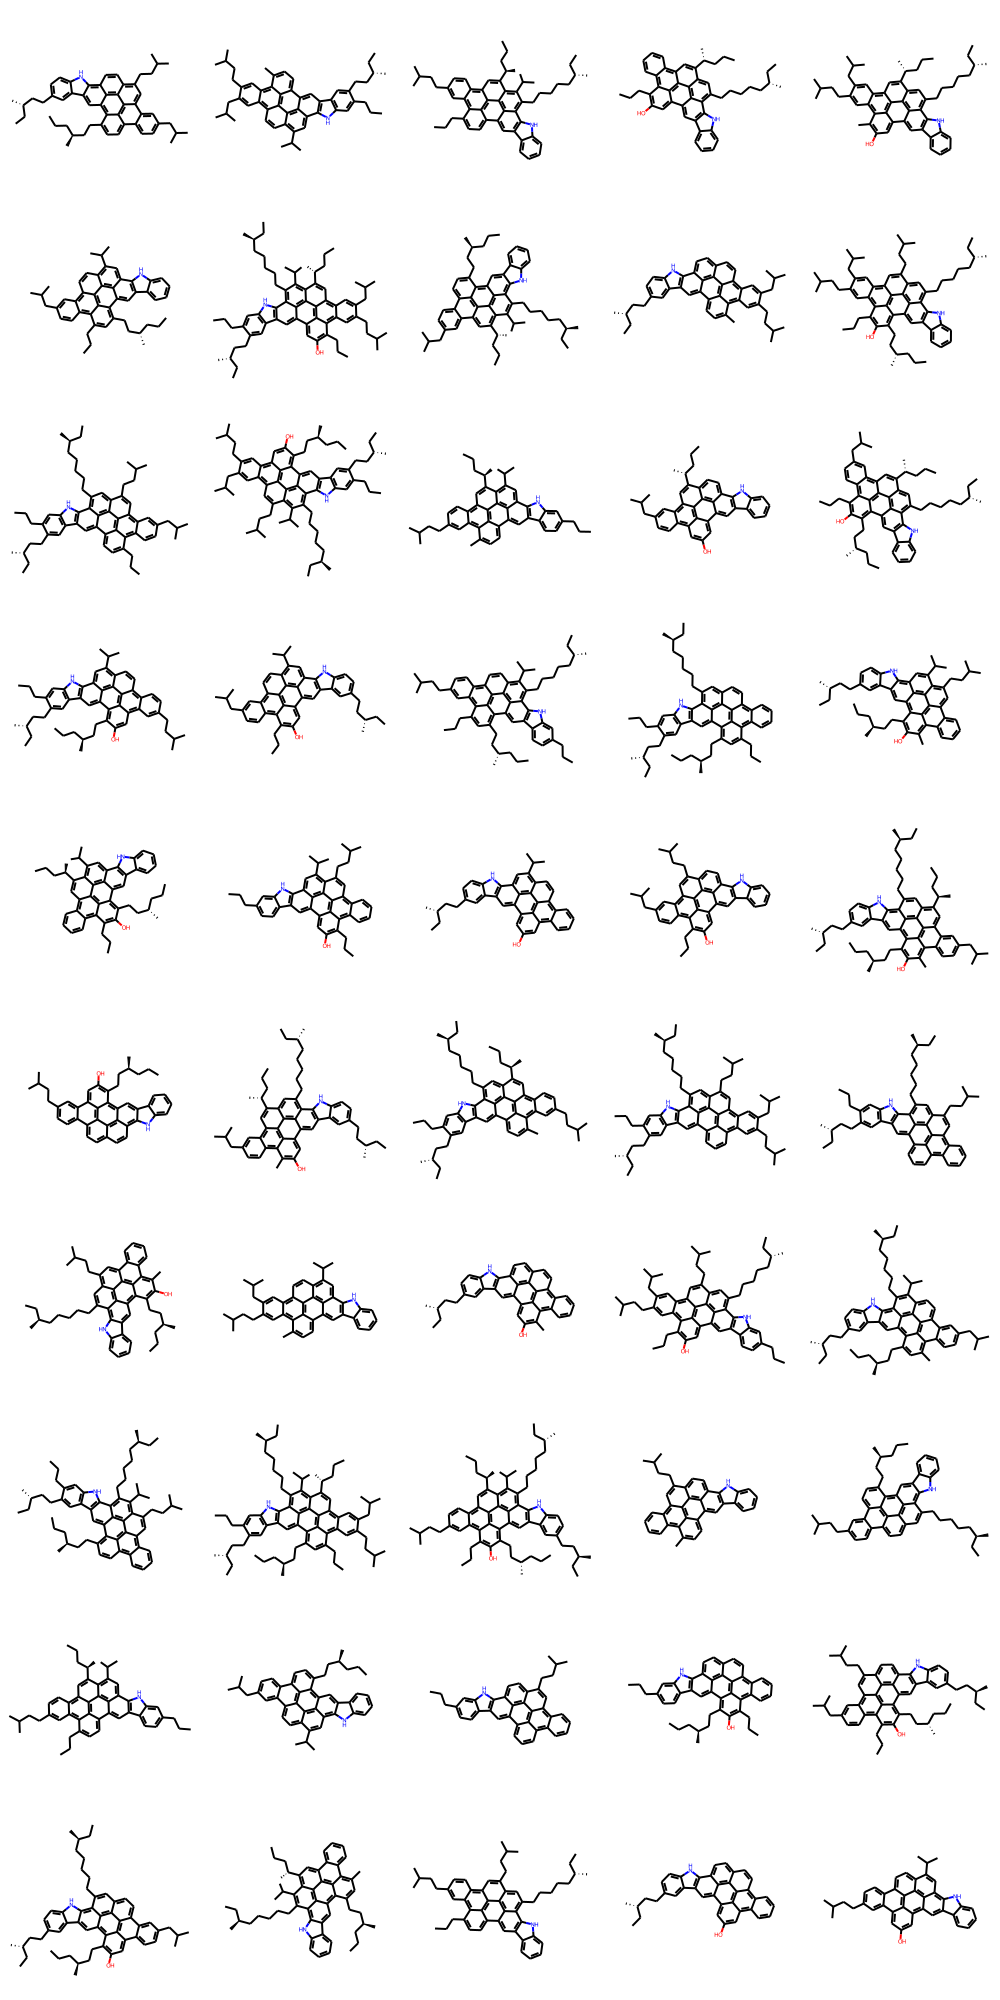

In [41]:
uniquemols=[]
for i in unique:
    uniquemols.append(Chem.MolFromSmiles(i))
print(len(uniquemols), "unique molecules generated")
Draw.MolsToGridImage(uniquemols[:100], molsPerRow=5)